In [1]:
# Import the necessary libraries

import csv
import nltk
import numpy as np
import networkx as nx
import random
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eleft\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eleft\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stpwds = set(nltk.corpus.stopwords.words("english")) # step as stopwords the english stopwords
stemmer = nltk.stem.PorterStemmer() # process for removing the commoner morphological and inflexional endings from words in English

In [3]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]
#print(testing_set)

###################
# random baseline #
###################

random_predictions = np.random.choice([0,1], size=len(testing_set))
random_predictions =list(zip(range(len(testing_set)),random_predictions))# zip: returns an iterator of tuples
#print(random_predictions)

In [4]:
header = ['id','category'] # add "ID" and "category" column headers

with open('random_predictions.csv','w',encoding='UTF8',newline='') as pred: # without newline='' empty rows
    csv_out = csv.writer(pred) # wirite in random_predictions
    csv_out.writerow(header) # add headers
    
    for row in random_predictions: # random predictions to csv
        csv_out.writerow(row)  # The writerow method writes a row of data into the specified file

## Beat the random Baseline

In [5]:
# open the training set: 1 if link, 0 either

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
training_set

[['9510123', '9502114', '1'],
 ['9707075', '9604178', '1'],
 ['9312155', '9506142', '0'],
 ['9911255', '302165', '0'],
 ['9701033', '209076', '0'],
 ['9710020', '9709228', '1'],
 ['9901042', '9510135', '1'],
 ['209146', '9502077', '0'],
 ['9705079', '9702201', '1'],
 ['3016', '9207067', '0'],
 ['9402099', '105041', '0'],
 ['9705061', '9503216', '1'],
 ['109090', '9107', '0'],
 ['107016', '9304156', '0'],
 ['9812004', '9212092', '0'],
 ['9401058', '9511114', '0'],
 ['12261', '202126', '0'],
 ['207246', '9807137', '1'],
 ['9501144', '9311081', '1'],
 ['9304048', '9510008', '0'],
 ['9607172', '9811090', '0'],
 ['1044', '109063', '0'],
 ['110087', '9711200', '1'],
 ['9411028', '9909017', '0'],
 ['9501105', '9202069', '1'],
 ['9712216', '9802184', '0'],
 ['5281', '11003', '0'],
 ['9705154', '105217', '0'],
 ['9708164', '9510017', '1'],
 ['107114', '103167', '0'],
 ['11109', '3298', '1'],
 ['211247', '11237', '0'],
 ['9601055', '9404188', '1'],
 ['9239', '9203051', '1'],
 ['2094', '9811089',

In [6]:
# open the node information

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
publication_year=[element[1] for element in node_info]
paper_title=[element[2] for element in node_info]
authors=[element[3] for element in node_info]
journal=[element[4] for element in node_info]
abstract=[element[5] for element in node_info]

In [7]:
# Define some functions that we will use later

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)


def issamejournal(source_journal, target_journal):    
    if source_journal == target_journal: 
        same_journal = 1
    else:
        same_journal = 0
    return same_journal


def isselfcite(source_auth, target_auth): 
    selfcite = 0
    for sauth in source_auth: 
        if sauth in target_auth: 
            selfcite = 1
            break 
    return selfcite

## TF-ID: transform abstract into representation of numbers
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(abstract)

## Prepare the features for the training set

In [ ]:
# Create empty lists to store the features

tfidf_similarity_abstracts=[] # cosine similarity between abstracts
overlap_title=[] # common words in titles
temp_diff=[] # difference between dates published
comm_auth=[] #common authors
overlap_abstract=[] # common words in abstracts
same_journal=[] # check if two papers pyblished in the same journal
jaccard=[] # jaccard similarity
self_cite=[]

In [ ]:
counter = 0

for i in range(len(training_set)):
    source = training_set[i][0] # row i (all the rows), column 0: first paper
    target = training_set[i][1] # row i (all the rows), column 1: second paper
    
    index_source = IDs.index(source) # ID of every source
    index_target = IDs.index(target)  # ID of every target
    
    source_info = [element for element in node_info if element[0]==source][0] # information for all the source papers
    target_info = [element for element in node_info if element[0]==target][0] # information for all the target papers
    
    
    # TITLE
    source_title = source_info[2].lower().split(" ") # convert title to lowercase and tokenize
    source_title = [token for token in source_title if token not in stpwds]  # remove stopwords in the title
    source_title = [stemmer.stem(token) for token in source_title] #stemming
    
    target_title = target_info[2].lower().split(" ") # convert title to lowercase and tokenize
    target_title = [token for token in target_title if token not in stpwds]  # remove stopwords in the title
    target_title = [stemmer.stem(token) for token in target_title] #stemming
    
    # abstract
    source_abstract = source_info[5].lower().split(" ") # convert title to lowercase and tokenize
    source_abstract = [token for token in source_abstract if token not in stpwds]  # remove stopwords in the title
    source_abstract = [stemmer.stem(token) for token in source_abstract] #stemming
    
    target_abstract = target_info[5].lower().split(" ") # convert title to lowercase and tokenize
    target_abstract = [token for token in target_abstract if token not in stpwds]  # remove stopwords in the title
    target_abstract = [stemmer.stem(token) for token in target_abstract] #stemming
    
    
    # AUTHORS
    source_auth = source_info[3].split(",") # split the multiple authors by comma
    target_auth = target_info[3].split(",")   
   

    # same journal
    source_journal = source_info[4].lower()
    target_journal = target_info[4].lower()
    
    
    #tfidf cosine similarity
    tf1 = tfidf_matrix[index_source]# in case tfidf mat is so large that it's stored as a sparse matrix
    tf2 = tfidf_matrix[index_target]# in case tfidf mat is so largs that it's stared as a sparse matrix
    
    
    
    # Append in to lists
    
    overlap_title.append(len(set(source_title).intersection(set(target_title)))) # κοινοί τίτλοι
    temp_diff.append(int(source_info[1]) - int(target_info[1])) # difference between the public year
    comm_auth.append(len(set(source_auth).intersection(set(target_auth)))) # πόσους κοινούς authors έχουν
    overlap_abstract.append(len(set(source_abstract).intersection(set(target_abstract)))) # κοινοί τίτλοι
    same_journal.append(issamejournal(source_journal, target_journal))
    jaccard.append(jaccard_similarity(source_abstract,target_abstract))
    self_cite.append(isselfcite(source_auth,target_auth))
    tfidf_similarity_abstracts.append(cosine_similarity(tf1, tf2)[0][0])

    counter += 1

    if counter % 1000 == True:
        print (counter, "training examples processsed")
    

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

231001 training examples processsed
232001 training examples processsed
233001 training examples processsed
234001 training examples processsed
235001 training examples processsed
236001 training examples processsed
237001 training examples processsed
238001 training examples processsed
239001 training examples processsed
240001 training examples processsed
241001 training examples processsed
242001 training examples processsed
243001 training examples processsed
244001 training examples processsed
245001 training examples processsed
246001 training examples processsed
247001 training examples processsed
248001 training examples processsed
249001 training examples processsed
250001 training examples processsed
251001 training examples processsed
252001 training examples processsed
253001 training examples processsed
254001 training examples processsed
255001 training examples processsed
256001 training examples processsed
257001 training examples processsed
258001 training examples pro

459001 training examples processsed
460001 training examples processsed
461001 training examples processsed
462001 training examples processsed
463001 training examples processsed
464001 training examples processsed
465001 training examples processsed
466001 training examples processsed
467001 training examples processsed
468001 training examples processsed
469001 training examples processsed
470001 training examples processsed
471001 training examples processsed
472001 training examples processsed
473001 training examples processsed
474001 training examples processsed
475001 training examples processsed
476001 training examples processsed
477001 training examples processsed
478001 training examples processsed
479001 training examples processsed
480001 training examples processsed
481001 training examples processsed
482001 training examples processsed
483001 training examples processsed
484001 training examples processsed
485001 training examples processsed
486001 training examples pro

In [ ]:
# Store the features into a pandas dataframe
import pandas as pd
df=pd.DataFrame(training_set,columns=['Paper1','Paper2','Linked'])
df['common_words_in_title']=overlap_title
df['diff_between_date_published']=temp_diff
df['number_common_authos']=comm_auth
df['common_words_abstract']=overlap_abstract
df['same_journal']=same_journal
df['jaccard']=jaccard
df['self_cite']=self_cite
df['tfidf_similarity_abstracts']=tfidf_similarity_abstracts

In [ ]:
df

,Paper1,Paper2,Linked,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,9510123,9502114,1,2,0,0,4,1,0.061538,0,0.125091
1,9707075,9604178,1,1,1,0,7,0,0.112903,0,0.090347
2,9312155,9506142,0,0,-2,0,6,0,0.043165,0,0.083062
3,9911255,302165,0,0,-4,0,8,0,0.091954,0,0.089948
4,9701033,209076,0,0,-5,0,8,0,0.106667,0,0.199455
...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,1,2,4,0,3,0,0.035714,0,0.072603
615508,9709133,9202062,0,0,5,0,3,0,0.028571,0,0.071401
615509,7141,9610152,0,1,4,0,5,0,0.063291,0,0.103193
615510,207232,111196,1,0,1,0,0,1,0.000000,0,0.060739


In [ ]:
df.to_pickle('training_features')

In [ ]:
df.to_csv('training_features.csv')

## Prepare the features for the test set

In [ ]:
# Create empty lists to store the features

tfidf_similarity_abstracts_test=[] # cosine similarity between abstracts
overlap_title_test=[] # common words in titles
temp_diff_test=[] # difference between dates published
comm_auth_test=[] #common authors
overlap_abstract_test=[] # common words in abstracts
same_journal_test=[] # check if two papers pyblished in the same journal
jaccard_test=[] # jaccard similarity
self_cite_test=[]

In [ ]:
counter = 0


for i in range(len(testing_set)):
    source = testing_set[i][0] # row i (all the rows), column 0: first paper
    target = testing_set[i][1] # row i (all the rows), column 1: second paper
    
    index_source = IDs.index(source) # ID of every source
    index_target = IDs.index(target)  # ID of every target
    
    source_info = [element for element in node_info if element[0]==source][0] # information for all the source papers
    target_info = [element for element in node_info if element[0]==target][0] # information for all the target papers
    
    
    # TITLE
    source_title = source_info[2].lower().split(" ") # convert title to lowercase and tokenize
    source_title = [token for token in source_title if token not in stpwds]  # remove stopwords in the title
    source_title = [stemmer.stem(token) for token in source_title] #stemming
    
    target_title = target_info[2].lower().split(" ") # convert title to lowercase and tokenize
    target_title = [token for token in target_title if token not in stpwds]  # remove stopwords in the title
    target_title = [stemmer.stem(token) for token in target_title] #stemming
    
    # abstract
    source_abstract = source_info[5].lower().split(" ") # convert title to lowercase and tokenize
    source_abstract = [token for token in source_abstract if token not in stpwds]  # remove stopwords in the title
    source_abstract = [stemmer.stem(token) for token in source_abstract] #stemming
    
    target_abstract = target_info[5].lower().split(" ") # convert title to lowercase and tokenize
    target_abstract = [token for token in target_abstract if token not in stpwds]  # remove stopwords in the title
    target_abstract = [stemmer.stem(token) for token in target_abstract] #stemming
    
    
    # AUTHORS
    source_auth = source_info[3].split(",") # split the multiple authors by comma
    target_auth = target_info[3].split(",")   
   

    # same journal
    source_journal = source_info[4].lower()
    target_journal = target_info[4].lower()
    
    
    #tfidf cosine similarity
    tf1 = tfidf_matrix[index_source]# in case tfidf mat is so large that it's stored as a sparse matrix
    tf2 = tfidf_matrix[index_target]# in case tfidf mat is so largs that it's stared as a sparse matrix
    
    
    
    # Append in to lists
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title)))) # κοινοί τίτλοι
    temp_diff_test.append(int(source_info[1]) - int(target_info[1])) # difference between the public year
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth)))) # πόσους κοινούς authors έχουν
    overlap_abstract_test.append(len(set(source_abstract).intersection(set(target_abstract)))) # κοινοί τίτλοι
    same_journal_test.append(issamejournal(source_journal, target_journal))
    jaccard_test.append(jaccard_similarity(source_abstract,target_abstract))
    self_cite_test.append(isselfcite(source_auth,target_auth))
    tfidf_similarity_abstracts_test.append(cosine_similarity(tf1, tf2)[0][0])

    counter += 1

    if counter % 1000 == True:
        print (counter, "testing examples processsed")
    

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

In [ ]:
# Store the features into a pandas dataframe

import pandas as pd
df_test=pd.DataFrame(testing_set,columns=['Paper1','Paper2'])
df_test['common_words_in_title']=overlap_title_test
df_test['diff_between_date_published']=temp_diff_test
df_test['number_common_authos']=comm_auth_test
df_test['common_words_abstract']=overlap_abstract_test
df_test['same_journal']=same_journal_test
df_test['jaccard']=jaccard_test
df_test['self_cite']=self_cite_test
df_test['tfidf_similarity_abstracts']=tfidf_similarity_abstracts_test

In [ ]:
df_test.to_pickle('test_features')
df_test.to_csv('test_features.csv')

# GRAPH

- If we consider that the graph is **directed** it means that the nodes have a specific order. Assume that (u,v) a pair of nodes.It means that u is the initial node and v is the final node. So the direction is from u to v. We can not assume the opposite direction.


- Let's consider that the graph is **undirected** and let (u,v) be a pair of nodes. The direction could be from u to v or from v to u.

## Undirected Graph

In [ ]:
G = nx.Graph()

edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]
nodes = IDs
G.add_edges_from(edges)
G.add_nodes_from(nodes)

In [ ]:
G.number_of_nodes()
G.number_of_edges()

334690

In [ ]:
# Define some functions to use later

# common neighbors of two nodes in a graph
def common_neighbors(features, G):
    number_of_common_neighbors = []
    for i in range(features.shape[0]):
        a = features['Paper1'][i]
        b = features['Paper2'][i]
        number_of_common_neighbors.append(len(sorted(nx.common_neighbors(G, a, b)))) 
    return number_of_common_neighbors



def Jaccard_coef(features, G):
    J = []
    for i in range(features.shape[0]):
        a = features['Paper1'][i]
        b = features['Paper2'][i]
        pred = nx.jaccard_coefficient(G, [(a, b)])
        for u, v ,p in pred:
            J.append(p)
    return J


def is_same_cluster(partition, features):
    same_cluster = []
    for i in range(features.shape[0]):
        a = features['Paper1'][i]
        b = features['Paper2'][i]
        if(partition[a] == partition[b]):
            same_cluster.append(1)
        else:
            same_cluster.append(0)
    return same_cluster


def betweeness_diff(features, G):
    btw = nx.betweenness_centrality(G, 50) 
    btw_diff = []
    for i in range(features.shape[0]):
        a = features['Paper1'][i]
        b = features['Paper2'][i]
        btw_diff.append(btw[b] - btw[a])
    return btw_diff


def in_link_diff(features, G2):
    diff = []
    for i in range(features.shape[0]):
        a = features['Paper1'][i]
        b = features['Paper2'][i]
        diff.append(len(G2.in_edges(b)) - len(G2.in_edges(a)))
    return diff

In [ ]:
# create a dataframe with the training set. In these dataframe we will append all the graph features
import pandas as pd
graph_features = pd.DataFrame([[element[0], element[1]]for element in training_set],columns=['Paper1','Paper2'])
graph_features

,Paper1,Paper2
0,9510123,9502114
1,9707075,9604178
2,9312155,9506142
3,9911255,302165
4,9701033,209076
...,...,...
615507,9704211,9311015
615508,9709133,9202062
615509,7141,9610152
615510,207232,111196


In [ ]:
# create a dataframe with the test set. In these dataframe we will append all the graph features
import pandas as pd
graph_features_test = pd.DataFrame([[element[0], element[1]]for element in testing_set],columns=['Paper1','Paper2'])
graph_features_test

,Paper1,Paper2
0,9807076,9807139
1,109162,1182
2,9702187,9510135
3,111048,110115
4,9910176,9410073
...,...,...
32643,9705209,9305083
32644,9307023,9503118
32645,9608095,9205058
32646,9407008,106256


In [ ]:
# Graph features for training set

import community 

# Feature: number of common neighbors
number_common_neighbors = common_neighbors(graph_features,G)
graph_features['Number _of_common_neighbors'] = number_common_neighbors


# Feature: Jaccard coefficient
Jaccard = Jaccard_coef(graph_features,G)
graph_features['Jaccard_coefficient'] = Jaccard


# Feature: Check if two papers belong to the same cluster
partition = community.best_partition(G) #first compute the best partition
same_cluster_train = is_same_cluster(partition, graph_features)
graph_features['Same_cluster'] = same_cluster_train
graph_features

# Feature: Betweeness centrality
btw_diff = betweeness_diff(graph_features, G) # graph features as dataframe
graph_features['Betweeness_diff'] = btw_diff

In [ ]:
# Graph features for test set

import community 

# Feature: number of common neighbors
number_common_neighbors = common_neighbors(graph_features_test,G)
graph_features_test['Number _of_common_neighbors'] = number_common_neighbors


# Feature: Jaccard coefficient
Jaccard = Jaccard_coef(graph_features_test,G)
graph_features_test['Jaccard_coefficient'] = Jaccard


# Feature: Check if two papers belong to the same cluster
partition = community.best_partition(G) #first compute the best partition
same_cluster_test = is_same_cluster(partition, graph_features_test)
graph_features_test['Same_cluster'] = same_cluster_test
graph_features_test

# Feature: Betweeness centrality
btw_diff = betweeness_diff(graph_features_test, G) # graph features as dataframe
graph_features_test['Betweeness_diff'] = btw_diff

In [ ]:
#graph_features_new=pd.read_pickle(r'graph features') # read the pickle file as pandas dataframe
#graph_features_new

In [ ]:
# In order to define some features like the below one's graph features should be like a list

graph_features_list=[[element[0], element[1]] for element in training_set]
graph_features_list

graph_features_test_list=[[element[0], element[1]] for element in testing_set]
graph_features_test_list

def convert(list):
    return tuple(i for i in list)

convert(graph_features_list)
convert(graph_features_test_list)

(['9807076', '9807139'],
 ['109162', '1182'],
 ['9702187', '9510135'],
 ['111048', '110115'],
 ['9910176', '9410073'],
 ['9164', '9612141'],
 ['9411033', '9412038'],
 ['9411095', '9304102'],
 ['9603027', '301251'],
 ['9709080', '9702161'],
 ['7207', '9206070'],
 ['10143', '5040'],
 ['1135', '9711162'],
 ['9604070', '9503124'],
 ['9907036', '9611042'],
 ['3294', '9907022'],
 ['9407191', '9501095'],
 ['9811228', '9512046'],
 ['4003', '2160'],
 ['9708036', '9506102'],
 ['209068', '11125'],
 ['9310183', '111065'],
 ['9911195', '9807187'],
 ['9810179', '9802052'],
 ['9612068', '9801019'],
 ['9409020', '9707250'],
 ['11282', '6112'],
 ['212314', '101026'],
 ['208108', '11240'],
 ['12207', '302197'],
 ['206159', '109108'],
 ['209006', '9409068'],
 ['9208011', '9701116'],
 ['108020', '9139'],
 ['9908009', '9902116'],
 ['11133', '109042'],
 ['11251', '9405163'],
 ['9502124', '5135'],
 ['9702094', '9407087'],
 ['101103', '9506173'],
 ['9803080', '9703216'],
 ['9610105', '9410073'],
 ['9911133', 

In [ ]:
# Adamic-Adar coefficient
adamic_adar_coef=[]
adamic_adar=nx.adamic_adar_index(G, graph_features_list)
for u, v, p in adamic_adar:
    adamic_adar_coef.append(p)
    
graph_features['Adamic-Adar']=adamic_adar_coef


# Preferential attachment coefficient 
pref_attachement_coef=[]
pref_attachement = nx.preferential_attachment(G, graph_features_list)
for u, v, p in pref_attachement:
    pref_attachement_coef.append(p)
    
graph_features['Preferential attachment']=pref_attachement_coef

In [ ]:
# Adamic-Adar coefficient
adamic_adar_coef_test=[]
adamic_adar=nx.adamic_adar_index(G, graph_features_test_list)
for u, v, p in adamic_adar:
    adamic_adar_coef_test.append(p)
    
graph_features_test['Adamic-Adar']=adamic_adar_coef_test


# Preferential attachment coefficient 
pref_attachement_coef_test=[]
pref_attachement = nx.preferential_attachment(G, graph_features_test_list)
for u, v, p in pref_attachement:
    pref_attachement_coef_test.append(p)
    
graph_features_test['Preferential attachment']=pref_attachement_coef_test

In [ ]:
# graph_features.to_pickle('graph features') # store these features into a pickle file to make sure that we won't lose them
# graph_features_test.to_pickle('graph features_test')

In [ ]:
graph_features_test

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment
0,9807076,9807139,0,0.000000,0,-0.000207,0.000000,1062
1,109162,1182,24,0.074303,1,-0.002087,5.377973,13590
2,9702187,9510135,59,0.065338,1,0.003290,15.053612,164797
3,111048,110115,21,0.221053,1,0.000593,4.899424,3315
4,9910176,9410073,0,0.000000,1,0.000420,0.000000,1050
...,...,...,...,...,...,...,...,...
32643,9705209,9305083,1,0.010753,1,0.000093,0.281266,2184
32644,9307023,9503118,0,0.000000,0,0.000004,0.000000,24
32645,9608095,9205058,0,0.000000,0,0.000010,0.000000,702
32646,9407008,106256,0,0.000000,0,0.000079,0.000000,897


In [ ]:
#katz = nx.katz.katz_centrality(G,alpha=0.005,beta=1)
#katz

In [ ]:
# Import graph features
#df=pd.read_pickle(r'graph_features')
#df

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Adamic-Adar,Preferential attachment
0,9510123,9502114,1,0.058824,0,0.513898,72
1,9707075,9604178,20,0.097087,1,4.320366,11613
2,9312155,9506142,0,0.000000,0,0.000000,5
3,9911255,302165,0,0.000000,1,0.000000,280
4,9701033,209076,0,0.000000,0,0.000000,168
...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,1.692987,416
615508,9709133,9202062,0,0.000000,1,0.000000,30
615509,7141,9610152,0,0.000000,0,0.000000,270
615510,207232,111196,0,0.000000,0,0.000000,24


## Let's consider the graph as directed

In [ ]:
G1 = nx.DiGraph()
edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]
nodes = IDs
G1.add_edges_from(edges)
G1.add_nodes_from(nodes)
nx.is_directed(G1)

True

## Page rank and HITS Algorithm

In [ ]:
# a measure of the importance of a paper. Analyzing the quantity and quality of the links that point to it
page_rank = nx.pagerank_scipy(G1)

# high hub_score means that this node links to many other nodes
# high authority score means that many links point to this node
hub_score, authority_score = nx.hits(G1)

In [ ]:
hub_scores=[]
for i in list(graph_features['Paper1']):
    hub_scores.append(hub_score[i])
    
authority_scores=[]
for i in list(graph_features['Paper2']):
    authority_scores.append(authority_score[i])    
    
page_ranks=[]
for i in list(graph_features['Paper2']):
    page_ranks.append(page_rank[i])
    
graph_features['Page_rank']=page_ranks
graph_features['Authority_score']=authority_scores
graph_features['Hub_score']=hub_scores

In [ ]:
hub_scores_test=[]
for i in list(graph_features_test['Paper1']):
    hub_scores_test.append(hub_score[i])
    
authority_scores_test=[]
for i in list(graph_features_test['Paper2']):
    authority_scores_test.append(authority_score[i])    
    
page_ranks_test=[]
for i in list(graph_features_test['Paper2']):
    page_ranks_test.append(page_rank[i])
    
graph_features_test['Page_rank']=page_ranks_test
graph_features_test['Authority_score']=authority_scores_test
graph_features_test['Hub_score']=hub_scores_test

In [ ]:
# Feature: In-link difference
diff = in_link_diff(graph_features, G1) # graph features as dataframe
graph_features['In_link_diff'] = diff

In [ ]:
# Feature: In-link difference
diff = in_link_diff(graph_features_test, G1) # graph features as dataframe
graph_features_test['In_link_diff'] = diff

In [ ]:
graph_features

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,2.946040e-08,5
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,2.011730e-04,113
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,0.000000e+00,1
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,3.836694e-05,-2
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,0.000000e+00,-5
...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,5.875495e-07,45
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,6.785858e-226,0
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,1.349733e-05,0
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,1.089963e-06,2


In [ ]:
graph_features_test

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff
0,9807076,9807139,0,0.000000,0,-0.000207,0.000000,1062,0.000012,4.201273e-06,0.000246,-46
1,109162,1182,24,0.074303,1,-0.002087,5.377973,13590,0.000069,4.779221e-05,0.000253,-61
2,9702187,9510135,59,0.065338,1,0.003290,15.053612,164797,0.002588,3.320411e-03,0.000067,517
3,111048,110115,21,0.221053,1,0.000593,4.899424,3315,0.000016,3.620505e-05,0.000019,5
4,9910176,9410073,0,0.000000,1,0.000420,0.000000,1050,0.000879,6.548123e-04,0.000001,143
...,...,...,...,...,...,...,...,...,...,...,...,...
32643,9705209,9305083,1,0.010753,1,0.000093,0.281266,2184,0.000367,8.972854e-05,0.000059,43
32644,9307023,9503118,0,0.000000,0,0.000004,0.000000,24,0.000019,2.588466e-08,0.000000,4
32645,9608095,9205058,0,0.000000,0,0.000010,0.000000,702,0.000110,1.895048e-05,0.000106,5
32646,9407008,106256,0,0.000000,0,0.000079,0.000000,897,0.000026,5.549531e-06,0.000003,-2


In [ ]:
# Save Graph Features

#graph_features.to_pickle('graph_features')
graph_features.to_csv('graph_features.csv')

#graph_features_test.to_pickle('graph_features_test')
graph_features_test.to_csv('graph_features_test.csv')

### Explore and collect all the features

In [ ]:
import pandas as pd
df_training_graph=pd.read_pickle(r'graph_features') # read the pickle file as pandas dataframe
df_training_graph

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,2.946040e-08,5
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,2.011730e-04,113
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,0.000000e+00,1
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,3.836694e-05,-2
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,0.000000e+00,-5
...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,5.875495e-07,45
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,6.785858e-226,0
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,1.349733e-05,0
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,1.089963e-06,2


In [ ]:
# link=[element[2] for element in training_set]
# df_training_graph['linked']=link
# df_training_graph.to_pickle('training graph features')

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff,linked
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,2.946040e-08,5,1
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,2.011730e-04,113,1
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,0.000000e+00,1,0
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,3.836694e-05,-2,0
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,0.000000e+00,-5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,5.875495e-07,45,1
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,6.785858e-226,0,0
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,1.349733e-05,0,0
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,1.089963e-06,2,1


In [ ]:
df_training_graph

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff,linked
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,2.946040e-08,5,1
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,2.011730e-04,113,1
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,0.000000e+00,1,0
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,3.836694e-05,-2,0
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,0.000000e+00,-5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,5.875495e-07,45,1
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,6.785858e-226,0,0
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,1.349733e-05,0,0
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,1.089963e-06,2,1


In [ ]:
df_test_graph=pd.read_pickle(r'graph_features_test') # read the pickle file as pandas dataframe
df_test_graph

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff
0,9807076,9807139,0,0.000000,0,-0.000207,0.000000,1062,0.000012,4.201273e-06,0.000246,-46
1,109162,1182,24,0.074303,1,-0.002087,5.377973,13590,0.000069,4.779221e-05,0.000253,-61
2,9702187,9510135,59,0.065338,1,0.003290,15.053612,164797,0.002588,3.320411e-03,0.000067,517
3,111048,110115,21,0.221053,1,0.000593,4.899424,3315,0.000016,3.620505e-05,0.000019,5
4,9910176,9410073,0,0.000000,1,0.000420,0.000000,1050,0.000879,6.548123e-04,0.000001,143
...,...,...,...,...,...,...,...,...,...,...,...,...
32643,9705209,9305083,1,0.010753,1,0.000093,0.281266,2184,0.000367,8.972854e-05,0.000059,43
32644,9307023,9503118,0,0.000000,0,0.000004,0.000000,24,0.000019,2.588466e-08,0.000000,4
32645,9608095,9205058,0,0.000000,0,0.000010,0.000000,702,0.000110,1.895048e-05,0.000106,5
32646,9407008,106256,0,0.000000,0,0.000079,0.000000,897,0.000026,5.549531e-06,0.000003,-2


In [ ]:
import pandas as pd
df_training_textual=pd.read_pickle(r'training_features') # read the pickle file as pandas dataframe
df_training_textual

,Paper1,Paper2,Linked,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,9510123,9502114,1,2,0,0,4,1,0.061538,0,0.125091
1,9707075,9604178,1,1,1,0,7,0,0.112903,0,0.090347
2,9312155,9506142,0,0,-2,0,6,0,0.043165,0,0.083062
3,9911255,302165,0,0,-4,0,8,0,0.091954,0,0.089948
4,9701033,209076,0,0,-5,0,8,0,0.106667,0,0.199455
...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,1,2,4,0,3,0,0.035714,0,0.072603
615508,9709133,9202062,0,0,5,0,3,0,0.028571,0,0.071401
615509,7141,9610152,0,1,4,0,5,0,0.063291,0,0.103193
615510,207232,111196,1,0,1,0,0,1,0.000000,0,0.060739


In [ ]:
import pandas as pd
df_test_textual=pd.read_pickle(r'test_features') # read the pickle file as pandas dataframe
df_test_textual

,Paper1,Paper2,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,9807076,9807139,0,0,0,7,0,0.097222,0,0.147759
1,109162,1182,2,1,0,6,1,0.082192,0,0.175917
2,9702187,9510135,1,2,0,4,1,0.085106,0,0.171962
3,111048,110115,1,0,0,13,1,0.111111,0,0.162788
4,9910176,9410073,0,5,0,4,0,0.067797,0,0.297478
...,...,...,...,...,...,...,...,...,...,...
32643,9705209,9305083,3,4,0,13,0,0.091549,0,0.217487
32644,9307023,9503118,0,-2,0,1,0,0.013699,0,0.053018
32645,9608095,9205058,0,4,0,6,0,0.048000,0,0.148032
32646,9407008,106256,0,-7,0,3,1,0.035714,0,0.070066


## Concate all the features

#### Training features

In [ ]:
# concate all the training features
df_total_features_training = pd.concat([df_training_graph.iloc[:,0:13], df_training_textual.iloc[:,2:12]], axis=1)
df_total_features_training=df_total_features_training.drop(columns=['linked'])

In [ ]:
df_total_features_training

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,...,In_link_diff,Linked,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,...,5,1,2,0,0,4,1,0.061538,0,0.125091
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,...,113,1,1,1,0,7,0,0.112903,0,0.090347
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,...,1,0,0,-2,0,6,0,0.043165,0,0.083062
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,...,-2,0,0,-4,0,8,0,0.091954,0,0.089948
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,...,-5,0,0,-5,0,8,0,0.106667,0,0.199455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,...,45,1,2,4,0,3,0,0.035714,0,0.072603
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,...,0,0,0,5,0,3,0,0.028571,0,0.071401
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,...,0,0,1,4,0,5,0,0.063291,0,0.103193
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,...,2,1,0,1,0,0,1,0.000000,0,0.060739


In [ ]:
df_total_features_training.to_pickle('total_features_training.pkl') # save training features into pickle file

In [ ]:
df_total_features_training.to_csv('total_features_training.csv') # save training features into csv file

In [ ]:
df_total_features_training.columns

Index(['Paper1', 'Paper2', 'Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'Linked', 'common_words_in_title',
       'diff_between_date_published', 'number_common_authos',
       'common_words_abstract', 'same_journal', 'jaccard', 'self_cite',
       'tfidf_similarity_abstracts'],
      dtype='object')

#### Test features

In [ ]:
# concate all the training features
df_total_features_test = pd.concat([df_test_graph.iloc[:,0:13], df_test_textual.iloc[:,2:11]], axis=1)
#df_total_features_test=df_total_features_training.drop(columns=['linked'])

In [ ]:
df_total_features_training.columns

Index(['Paper1', 'Paper2', 'Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'Linked', 'common_words_in_title',
       'diff_between_date_published', 'number_common_authos',
       'common_words_abstract', 'same_journal', 'jaccard', 'self_cite',
       'tfidf_similarity_abstracts'],
      dtype='object')

In [ ]:
df_total_features_test.to_pickle('total_features_test.pkl') # save training features into pickle file

In [ ]:
df_total_features_test.to_csv('total_features_test.csv') # save training features into pickle file

So now we have a dataset with all the training features. This dataset is consisted of the follwing features:

- Number _of_common_neighbors
- Jaccard_coefficient
- Same_cluster
- Betweeness_diff 
- Adamic-Adar
- Preferential attachment
- Page_rank 
- Authority_score
- Hub_score 
- In_link_diff  
- common_words_in_title
- diff_between_date_published
- number_common_authos
- common_words_abstract
- same_journal'
- jaccard
- self_cite
- tfidf_similarity_abstracts

(18 in total)

## Exploratory Data Analysis

In [ ]:
import pandas as pd
df=pd.read_pickle('total_features_training.pkl')
df

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,...,In_link_diff,Linked,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,...,5,1,2,0,0,4,1,0.061538,0,0.125091
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,...,113,1,1,1,0,7,0,0.112903,0,0.090347
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,...,1,0,0,-2,0,6,0,0.043165,0,0.083062
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,...,-2,0,0,-4,0,8,0,0.091954,0,0.089948
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,...,-5,0,0,-5,0,8,0,0.106667,0,0.199455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,...,45,1,2,4,0,3,0,0.035714,0,0.072603
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,...,0,0,0,5,0,3,0,0.028571,0,0.071401
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,...,0,0,1,4,0,5,0,0.063291,0,0.103193
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,...,2,1,0,1,0,0,1,0.000000,0,0.060739


In [ ]:
df['Number _of_common_neighbors'].value_counts()

0       286908
1        25752
2        23795
3        22813
4        21936
         ...  
215          1
216          1
222          1
224          1
1421         1
Name: Number _of_common_neighbors, Length: 233, dtype: int64

In [ ]:
# Common neighbours
df_common_neighbours=df[df['Number _of_common_neighbors']==0]
df_common_neighbours[df_common_neighbours['Linked']=='1']
print('The percentage of papers that have zero common neighbours and exists a link between them = : ',
        round(
            (len(df_common_neighbours[df_common_neighbours['Linked']=='1'])
             /len(df[df['Number _of_common_neighbors']==0]))
            *100,2)
     )

The percentage of papers that have zero common neighbours and exists a link between them = :  5.85


In [ ]:
# common authors

df_common_authors=df[df['number_common_authos']==0]
print(len(df[df['number_common_authos']==0]))
print(len(df_common_authors[df_common_authors['Linked']=='1']))
print('The percentage of papers that have zero common authors and exists a link between them = : ',
      round((len(df_common_authors[df_common_authors['Linked']=='1'])
             /len(df[df['number_common_authos']==0]))
            *100,2)
     )

575841
301773
The percentage of papers that have zero common authors and exists a link between them = :  52.41


In [ ]:
# common title

df_common_title=df[df['common_words_in_title']==0]

#print(len(df[df['common_words_in_title']==0]))
#print(len(df_common_title[df_common_title['Linked']=='1']))

print('The percentage of papers that have zero common words in title and exists a link between them = : ',
      round((len(df_common_title[df_common_title['Linked']=='1'])
             /len(df[df['common_words_in_title']==0]))
            *100,2)
     )


# common title

df_common_title=df[df['common_words_in_title']!=0]

#print(len(df[df['common_words_in_title']!=0]))
#print(len(df_common_title[df_common_title['Linked']=='1']))
print('The percentage of papers that have at least one common word in title and exists a link between them = : ',
      round((len(df_common_title[df_common_title['Linked']=='1'])
             /len(df[df['common_words_in_title']!=0]))
            *100,2)
     )

The percentage of papers that have zero common words in title and exists a link between them = :  41.18
The percentage of papers that have at least one common word in title and exists a link between them = :  82.35


In [ ]:
# cosine similarity

df_cosine_similarity=df[df['tfidf_similarity_abstracts']>0.5]

print('The percentage of papers that have cosine similarity>0.5 and exists a link between them = : ',
      round((len(df_cosine_similarity[df_cosine_similarity['Linked']=='1'])
             /len(df[df['tfidf_similarity_abstracts']> 0.5]))
            *100,2)
     )

The percentage of papers that have cosine similarity>0.5 and exists a link between them = :  100.0


In [ ]:
# Self - Cite 
df['self_cite'].value_counts()

df_self_cite=df[df['self_cite']==1]

print('The percentage of papers that self_cite = 1 and exists a link between them = : ',
      round((len(df_self_cite[df_self_cite['Linked']=='1'])
             /len(df[df['self_cite']==1]))
            *100,2)
     )

df_self_cite=df[df['self_cite']==0]

print('The percentage of papers that self_cite = 0 and exists a link between them = : ',
      round((len(df_self_cite[df_self_cite['Linked']=='1'])
             /len(df[df['self_cite']==0]))
            *100,2)
     )

The percentage of papers that self_cite = 1 and exists a link between them = :  84.08
The percentage of papers that self_cite = 0 and exists a link between them = :  52.41


**So of those papers that have no common neighbours only 5.85% have a link between them. Therefore there is a strong indication that if two papers have no common neighbours between them , it is less possible to have a link.**

## Feature Selection

- **Geaph Feature Selection**

In [ ]:
import pandas as pd
df_training_graph=pd.read_pickle(r'graph_features') # read the pickle file as pandas dataframe
df_training_graph

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,2.946040e-08,5
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,2.011730e-04,113
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,0.000000e+00,1
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,3.836694e-05,-2
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,0.000000e+00,-5
...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,5.875495e-07,45
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,6.785858e-226,0
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,1.349733e-05,0
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,1.089963e-06,2


In [ ]:
link=[element[2] for element in training_set]
df_training_graph['linked']=link
df_training_graph.to_pickle('training graph features')

In [ ]:
df_training_graph

,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,Authority_score,Hub_score,In_link_diff,linked
0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,5.785598e-06,2.946040e-08,5,1
1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,4.746958e-04,2.011730e-04,113,1
2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,9.646275e-08,0.000000e+00,1,0
3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,1.425689e-05,3.836694e-05,-2,0
4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,1.123762e-05,0.000000e+00,-5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,2.402220e-05,5.875495e-07,45,1
615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,1.451031e-06,6.785858e-226,0,0
615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,4.312844e-07,1.349733e-05,0,0
615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,1.782542e-07,1.089963e-06,2,1


In [ ]:
# training features
training_features =df_training_graph.iloc[:,2:12]


# scale training features
from sklearn import preprocessing
training_features = preprocessing.scale(training_features)
training_features

# labels
import numpy as np
labels = df_training_graph.iloc[:,12] # linked or not
labels = np.array(labels)

In [ ]:
# Train a Random Forest to find the importance of each feature
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(training_features,labels)

importances = model.feature_importances_
importances

array([0.12063489, 0.24668186, 0.10272183, 0.01942346, 0.34437431,
       0.0407234 , 0.05258837, 0.03158866, 0.02412278, 0.01714044])

In [ ]:
forest_importances = pd.Series(importances,index=['Number of common neighbors',
       'Jaccard coefficient', 'In same cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page rank', 'Authority score', 'Hub score',
       'In_link_diff'])

type(forest_importances)

# Pd series into dataframe in order to be able to plot
category = forest_importances.value_counts()  
category_df = forest_importances.reset_index()
category_df.columns = ['features', 'importance']

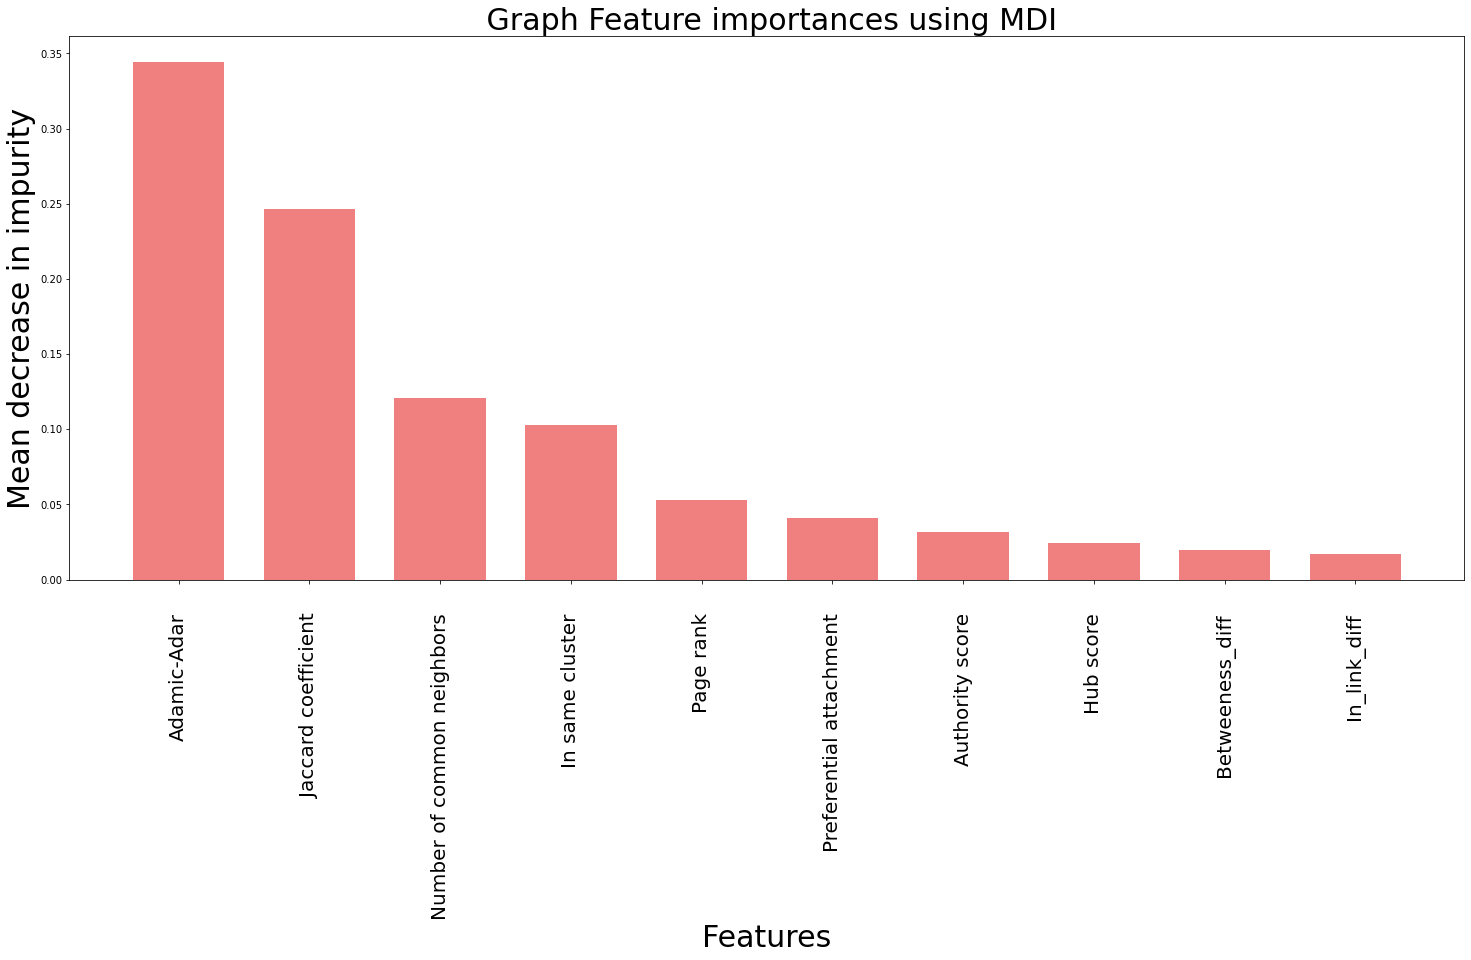

In [ ]:
# Plot the importances

fig, ax = plt.subplots(figsize = (25, 10))


# sort the values to see the countries in an ascending order by number of cases in order to extract conclusions easier
df=category_df.sort_values('importance',ascending=False) 

# creating the bar plot
ax.bar(df['features'],df['importance'],color ='lightcoral',width = 0.7) 
ax.set_xlabel("Features",size=30) 
ax.set_ylabel("Mean decrease in impurity",size=30) 
ax.set_xticks(range(len(df['features'])), df['features'], rotation='vertical',size=20) 
ax.set_xticklabels(df['features'] ,rotation='vertical',size=20)
ax.tick_params(axis='x', which='major', pad=30)
ax.set_title(" Graph Feature importances using MDI",size=30)
plt.savefig('Feature importances.png')
plt.show()

- **Textual Feature Selection**

In [ ]:
import pandas as pd
df_training_textual=pd.read_pickle(r'training_features') # read the pickle file as pandas dataframe
df_training_textual

,Paper1,Paper2,Linked,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,9510123,9502114,1,2,0,0,4,1,0.061538,0,0.125091
1,9707075,9604178,1,1,1,0,7,0,0.112903,0,0.090347
2,9312155,9506142,0,0,-2,0,6,0,0.043165,0,0.083062
3,9911255,302165,0,0,-4,0,8,0,0.091954,0,0.089948
4,9701033,209076,0,0,-5,0,8,0,0.106667,0,0.199455
...,...,...,...,...,...,...,...,...,...,...,...
615507,9704211,9311015,1,2,4,0,3,0,0.035714,0,0.072603
615508,9709133,9202062,0,0,5,0,3,0,0.028571,0,0.071401
615509,7141,9610152,0,1,4,0,5,0,0.063291,0,0.103193
615510,207232,111196,1,0,1,0,0,1,0.000000,0,0.060739


In [ ]:
# training features
training_features =df_training_textual.iloc[:,3:12]


# scale training features
from sklearn import preprocessing
training_features = preprocessing.scale(training_features)
training_features

# labels
import numpy as np
labels = df_training_textual.iloc[:,2] # linked or not
labels = np.array(labels)

In [ ]:
# Train a Random Forest to find the importance of each feature
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(training_features,labels)

importances = model.feature_importances_
importances

array([0.05977543, 0.23638283, 0.00475549, 0.07464417, 0.00347469,
       0.21998866, 0.00353235, 0.39744639])

In [ ]:
forest_importances = pd.Series(importances,index=['Common words in title',
       'Diff between date published', 'Number of common authors',
       'Common words in abstract', 'Same journal', 'jaccard', 'Self cite',
       'Cosine similarity'])

type(forest_importances)

# Pd series into dataframe in order to be able to plot
category = forest_importances.value_counts()  
category_df = forest_importances.reset_index()
category_df.columns = ['features', 'importance']

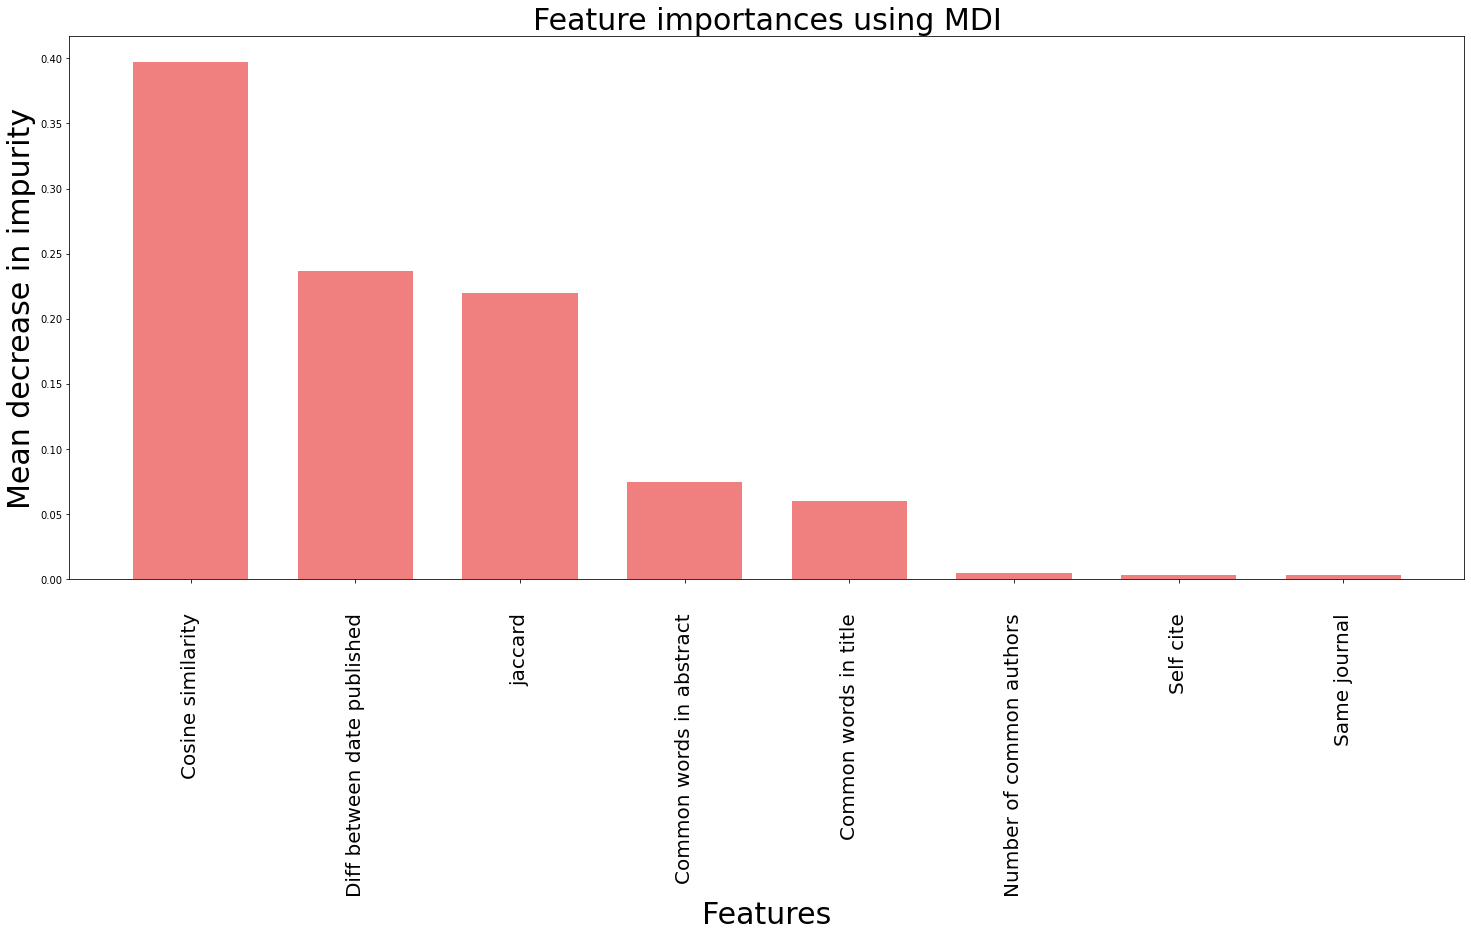

In [ ]:
# Plot the importances

fig, ax = plt.subplots(figsize = (25, 10))


# sort the values to see the countries in an ascending order by number of cases in order to extract conclusions easier
df=category_df.sort_values('importance',ascending=False) 

# creating the bar plot
ax.bar(df['features'],df['importance'],color ='lightcoral',width = 0.7) 
ax.set_xlabel("Features",size=30) 
ax.set_ylabel("Mean decrease in impurity",size=30) 
ax.set_xticks(range(len(df['features'])), df['features'], rotation='vertical',size=20) 
ax.set_xticklabels(df['features'] ,rotation='vertical',size=20)
ax.tick_params(axis='x', which='major', pad=30)
ax.set_title("Feature importances using MDI",size=30)
plt.savefig('Feature importances.png')
plt.show()

- **Total Feature Selection**

Since we have a lot of features it is worthful to examine which of them determine in a high degree if two papers are linked oe not.

Train a Random forest to find the most important **features**.

In [3]:
import pandas as pd
df_training=pd.read_pickle(r'total_features_training.pkl') # training features
df_test=pd.read_pickle(r'total_features_test.pkl') # test features

In [4]:
df_training.columns

Index(['Paper1', 'Paper2', 'Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'Linked', 'common_words_in_title',
       'diff_between_date_published', 'number_common_authos',
       'common_words_abstract', 'same_journal', 'jaccard', 'self_cite',
       'tfidf_similarity_abstracts'],
      dtype='object')

In [5]:
# training features
training_features =df_training.iloc[:,2:22]
training_features=training_features.drop('Linked',axis=1)
training_features

# scale training features
from sklearn import preprocessing
training_features = preprocessing.scale(training_features)
training_features

# test features
test_features=df_test.iloc[:,2:20]

# scale test features
test_features=preprocessing.scale(test_features)
test_features

# labels
import numpy as np
labels = df_training.iloc[:,12] # linked or not
labels = np.array(labels)

In [ ]:
# Train a Random Forest to find the importance of each feature
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(training_features,labels)

importances = model.feature_importances_
importances

array([0.14686318, 0.20029221, 0.07863989, 0.01068652, 0.32586003,
       0.03234201, 0.02380082, 0.01680837, 0.0126676 , 0.01361944,
       0.0050786 , 0.04997679, 0.0007236 , 0.01026431, 0.00091289,
       0.02858001, 0.00057673, 0.04230699])

In [ ]:
# save to csv file
#from numpy import savetxt
#savetxt('Feature importances.csv', importances, delimiter=',')

In [ ]:
forest_importances = pd.Series(importances,index=['Number of common neighbors',
       'Jaccard coefficient', 'In same cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Pag rank', 'Authority score', 'Hub score',
       'In_link_diff','Common words in title',
       'Diff between date published', 'Number of common authors',
       'Common words in abstract', 'Same journal', 'jaccard', 'Self cite',
       'Cosine similarity'])

type(forest_importances)

# Pd series into dataframe in order to be able to plot
category = forest_importances.value_counts()  
category_df = forest_importances.reset_index()
category_df.columns = ['features', 'importance']

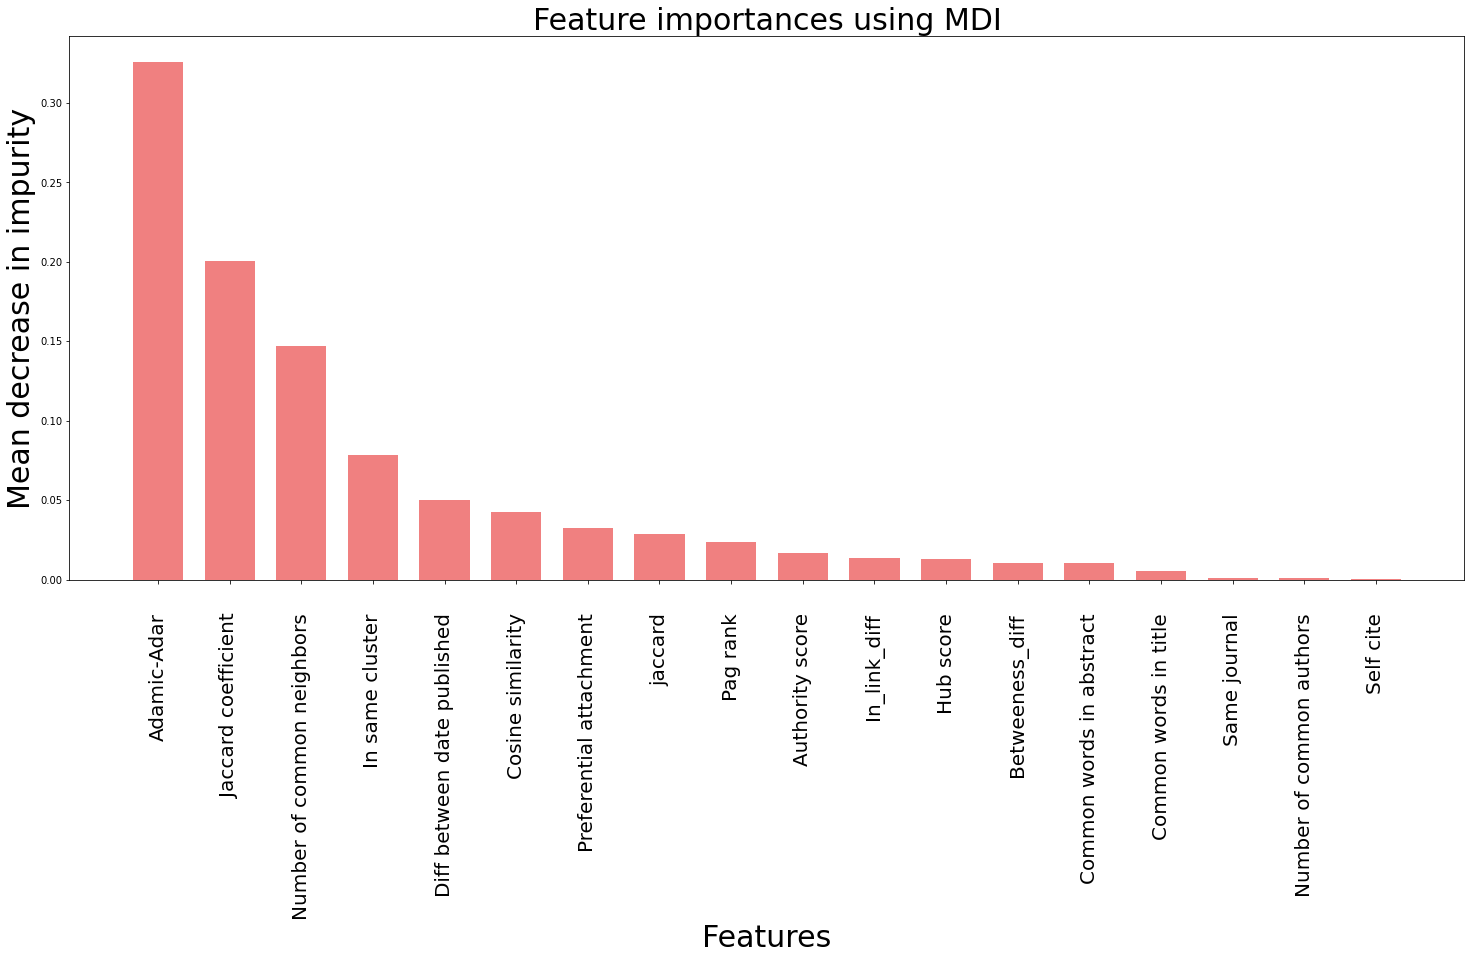

In [ ]:
# Plot the importances

fig, ax = plt.subplots(figsize = (25, 10))


# sort the values to see the countries in an ascending order by number of cases in order to extract conclusions easier
df=category_df.sort_values('importance',ascending=False) 

# creating the bar plot
ax.bar(df['features'],df['importance'],color ='lightcoral',width = 0.7) 
ax.set_xlabel("Features",size=30) 
ax.set_ylabel("Mean decrease in impurity",size=30) 
ax.set_xticks(range(len(df['features'])), df['features'], rotation='vertical',size=20) 
ax.set_xticklabels(df['features'] ,rotation='vertical',size=20)
ax.tick_params(axis='x', which='major', pad=30)
ax.set_title("Feature importances using MDI",size=30)
plt.savefig('Feature importances.png')
plt.show()

## Train a Random forest to find the best parameters for feature importance

**RFEC**

Because of the training time, GPU was required so we ran a piece of code in Google Colab that provides free GPU in order to speed the procedure.

In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive') # mount / add Google Drive to Colab

Mounted at /content/drive


In [ ]:
# import the files to drive
from google.colab import files
uploaded = files.upload()

Saving total_features_training.csv to total_features_training.csv


In [ ]:
# !pip3 install pickle5


     |████████████████████████████████| 256 kB 25.6 MB/s 


In [2]:
import pandas as pd
# read the file.. find the path from file on the left
df_test= pd.read_csv(r'/content/drive/MyDrive/total_features_test.csv') #import dataset as pandas dataframe
df_training=pd.read_csv(r'/content/drive/MyDrive/total_features_training.csv')

In [ ]:
df_training

,Unnamed: 0,Paper1,Paper2,Number _of_common_neighbors,Jaccard_coefficient,Same_cluster,Betweeness_diff,Adamic-Adar,Preferential attachment,Page_rank,...,In_link_diff,Linked,common_words_in_title,diff_between_date_published,number_common_authos,common_words_abstract,same_journal,jaccard,self_cite,tfidf_similarity_abstracts
0,0,9510123,9502114,1,0.058824,0,0.000031,0.513898,72,0.000026,...,5,1,2,0,0,4,1,0.061538,0,0.125091
1,1,9707075,9604178,20,0.097087,0,-0.000017,4.320366,11613,0.000204,...,113,1,1,1,0,7,0,0.112903,0,0.090347
2,2,9312155,9506142,0,0.000000,0,0.000009,0.000000,5,0.000017,...,1,0,0,-2,0,6,0,0.043165,0,0.083062
3,3,9911255,302165,0,0.000000,1,-0.000002,0.000000,280,0.000011,...,-2,0,0,-4,0,8,0,0.091954,0,0.089948
4,4,9701033,209076,0,0.000000,0,0.000009,0.000000,168,0.000011,...,-5,0,0,-5,0,8,0,0.106667,0,0.199455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615507,615507,9704211,9311015,5,0.090909,1,0.000178,1.692987,416,0.000139,...,45,1,2,4,0,3,0,0.035714,0,0.072603
615508,615508,9709133,9202062,0,0.000000,0,-0.000039,0.000000,30,0.000028,...,0,0,0,5,0,3,0,0.028571,0,0.071401
615509,615509,7141,9610152,0,0.000000,0,0.000016,0.000000,270,0.000017,...,0,0,1,4,0,5,0,0.063291,0,0.103193
615510,615510,207232,111196,0,0.000000,0,-0.000024,0.000000,24,0.000019,...,2,1,0,1,0,0,1,0.000000,0,0.060739


In [3]:
# training features
training_features =df_training.iloc[:,3:22]
training_features=training_features.drop('Linked',axis=1)
training_features

# scale training features
from sklearn import preprocessing
training_features = preprocessing.scale(training_features)
#training_features=pd.DataFrame(training_features_scale,columns=list(training_features.columns))

# test features
test_features=df_test.iloc[:,2:20]

# scale test features
test_features=preprocessing.scale(test_features)
test_features

# labels
import numpy as np   
labels = df_training.iloc[:,13] # linked or not
labels = np.array(labels)
#labels=pd.DataFrame(labels_array,columns=['Linked'])

In [10]:
%%time
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

# defining parameter range
#param_grid = { 
#    'n_estimators': [100,200,300,500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
#}
 
#grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
#grid.fit(X_train, y_train)

# model = RandomForestClassifier()  # we tried Gridsearch in this point but we didn't carry on with it due the training time
# model.fit(training_features,labels)

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 16.2 µs


In [11]:
labels

array([1, 1, 0, ..., 0, 1, 1])

In [15]:
%%time
# RFECV in order to find the optimal subset of features

from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
 
f1_scorer = make_scorer(f1_score, pos_label=1)

## according to the Random forest we use cross-validation in order to select the optimal subset of features
rfe = RFECV(RandomForestClassifier(),cv=4,scoring=f1_scorer)
rfe.fit(training_features,labels)

CPU times: user 2h 35min 56s, sys: 50.2 s, total: 2h 36min 46s
Wall time: 2h 36min 1s


In [17]:
import pickle
# save the model to disk 
filename = 'RFECV_colab.sav'
pickle.dump(rfe, open(filename, 'wb'))

In [18]:
!cp -r  "/content/RFECV_colab.sav" "/content/drive/MyDrive/"
print("model saved to Google Drive") 

model saved to Google Drive


In [19]:
 rfe.support_   

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True])

RFE suggested to include all the features except of "self cite" and "same journal"

## MODELS

In [6]:
import pandas as pd
df_training=pd.read_pickle(r'total_features_training.pkl') # training features
df_test=pd.read_pickle(r'total_features_test.pkl') # test features

In [7]:
df_training.columns

Index(['Paper1', 'Paper2', 'Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'Linked', 'common_words_in_title',
       'diff_between_date_published', 'number_common_authos',
       'common_words_abstract', 'same_journal', 'jaccard', 'self_cite',
       'tfidf_similarity_abstracts'],
      dtype='object')

In [8]:
# labels
import numpy as np
labels = df_training.iloc[:,12] # linked or not
labels = np.array(labels)

## SVM with all the features except of same journal, number of common authors ans self cite

In [6]:
%%time
# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

from sklearn import preprocessing
from sklearn.metrics import f1_score

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]

test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = svm.LinearSVC(max_iter=100000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_SVM = list(classifier.predict(test_features))
len(test_features)

import csv
from sklearn.metrics import f1_score

with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_SVM=np.array(predictions_SVM)
predictions_SVM
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_SVM,pos_label='1'))

F1-score=:  0.9634846113719353
Wall time: 27min 56s


## SVM with RBF kernel

In [13]:
%%time
# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

from sklearn import preprocessing
from sklearn.metrics import f1_score

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]

test_features=preprocessing.scale(test_features)
test_features


from sklearn.svm import SVC
# initialize basic SVM
classifier = SVC(kernel='rbf',max_iter=100000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_SVM_rbf = list(classifier.predict(test_features))
len(test_features)

import csv
from sklearn.metrics import f1_score

with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_SVM_rbf=np.array(predictions_SVM_rbf)
predictions_SVM_rbf
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_SVM_rbf,pos_label='1'))

F1-score=:  0.9724502932341582
Wall time: 1h 26min 14s


## Random Forest with all the features except of same journal, number of common authors ans self cite

In [13]:
%%time
# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

# initialize basic SVM
classifier = RandomForestClassifier()

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_forest = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_forest=np.array(predictions_forest)
predictions_forest
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_forest,pos_label='1'))

F1-score=:  0.9737392250637189
Wall time: 3min 47s


In [14]:
import pickle
# save the model to disk 
filename = 'Random_Forest.sav'
pickle.dump(classifier, open(filename, 'wb'))

## LIGHT GBM

In [9]:
%%time
# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features


import lightgbm as lgb
classifier = lgb.LGBMClassifier()
# train
classifier.fit(training_features, labels)


# issue predictions

predictions_lgb = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_lgb=np.array(predictions_lgb)
predictions_lgb
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_lgb,pos_label='1'))

F1-score=:  0.965145900880037
Wall time: 4.44 s


## Logistic Regression

In [15]:
%%time
from sklearn.linear_model import LogisticRegression

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9657202216066483
Wall time: 7.85 s


**Logistic regression is the  faster model. So we experiment on it to see its performance if we remove some features.**

Remove **common words in title**

In [21]:
%%time
from sklearn.linear_model import LogisticRegression

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'common_words_abstract','Authority_score', 'Hub_score',
       'In_link_diff',
       'diff_between_date_published',
        'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9272577389920122
Wall time: 6.3 s


Remove in addition **common words in abstract**

In [22]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff',
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff',
       'diff_between_date_published',
        'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9650773493419533
Wall time: 7.56 s


Remove **Betweeness Diff**

In [8]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff',
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster','Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff',
       'diff_between_date_published',
        'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9652723651164805
Wall time: 7.91 s


## Remove Hub score

In [20]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score',
       'In_link_diff',
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster','Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score',
       'In_link_diff',
       'diff_between_date_published',
        'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9655072882089768
Wall time: 6.9 s


## Remove link difference

In [22]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 
       'Authority_score',
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster','Adamic-Adar',
       'Preferential attachment', 'Page_rank', 
      'Authority_score',
       'diff_between_date_published',
        'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9642403235124206
Wall time: 7.83 s


## Remove Authority

In [16]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9638874443866642
Wall time: 6.09 s


# Remove Page rank

In [17]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment',
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 
       'diff_between_date_published',
       'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9627208838245077
Wall time: 5.37 s


## Remove Jaccard

In [18]:
%%time

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment',
       'diff_between_date_published',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Adamic-Adar',
       'Preferential attachment', 
       'diff_between_date_published',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features

from sklearn import svm
# initialize basic SVM
classifier = LogisticRegression(max_iter=10000)

# train
classifier.fit(training_features, labels)


# issue predictions

predictions_logistic = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_logistic=np.array(predictions_logistic)
predictions_logistic
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_logistic,pos_label='1'))

F1-score=:  0.9613157285151726
Wall time: 4.68 s


#### Conclusion : Removing features one by one, we notice the F1-score  decreases with comparison with the initial that we found with Logistic Regression. The change is not very significant. However we decided to carry on with all the features that we selected.

 ## GRIDSEARCH TO THE BEST MODEL

In [7]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# training features
training_features =df_training[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
training_features

# scale
training_features = preprocessing.scale(training_features)
training_features


test_features = df_test[['Number _of_common_neighbors',
       'Jaccard_coefficient', 'Same_cluster', 'Betweeness_diff', 'Adamic-Adar',
       'Preferential attachment', 'Page_rank', 'Authority_score', 'Hub_score',
       'In_link_diff', 'common_words_in_title',
       'diff_between_date_published',
       'common_words_abstract', 'jaccard',
       'tfidf_similarity_abstracts']]
test_features=preprocessing.scale(test_features)
test_features


param_grid = { 
    'n_estimators': [200,300,500],
    'max_depth' : [4,6,8]
}


# Find the best parameters for Random Forest
classifier = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 3)
classifier.fit(training_features, labels)


# issue predictions

predictions_forest = list(classifier.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_forest=np.array(predictions_forest)
predictions_forest
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_forest,pos_label='1'))

F1-score=:  0.9744323056683636
Wall time: 2h 48min 31s


In [9]:
print("Best parameters:", classifier.best_params_)

Best parameters: {'max_depth': 8, 'n_estimators': 500}


## VOTING CLASSIFIER

In [10]:
%%time
#import Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#instantiating three classifiers
# initialize basic SVM
classifier = SVC(kernel='rbf',max_iter=100000)
rf= RandomForestClassifier(max_depth= 8,n_estimators=500)
log=LogisticRegression(max_iter=10000)

voting_clf = VotingClassifier(estimators=[('SVC', classifier),('RandomForest',rf),('Logistic',log)], voting='hard')

# voting_clf = VotingClassifier(estimators=[('SVC', classifier),('RandomForest',rf),('Logistic',log)], voting='soft')

# we took an attribute error when we tried soft voting that is recommended for so good classifiers

# issue predictions
voting_clf.fit(training_features, labels)

predictions_voting = list(voting_clf.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_voting=np.array(predictions_voting)
predictions_voting
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_voting,pos_label='1'))

F1-score=:  0.9732332206109934
Wall time: 2h 8min 7s


**Try Voting Classifier with soft voting** --> Error!

In [9]:
%%time
#import Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#instantiating three classifiers
# initialize basic SVM
classifier = SVC(kernel='rbf',max_iter=100000)
rf= RandomForestClassifier(max_depth= 8,n_estimators=500)
log=LogisticRegression(max_iter=10000)

voting_clf = VotingClassifier(estimators=[('SVC', classifier),('RandomForest',rf),('Logistic',log)], voting='soft')
# issue predictions
voting_clf.fit(training_features, labels)

predictions_voting = list(voting_clf.predict(test_features))
len(test_features)

import csv
with open("solutions.csv", "r") as f:
    reader = csv.reader(f)
    true_values = [] 
    for line in reader:
        true_values.append(line[1])
true_values=true_values[1:]

true_values=np.array(true_values)
true_values
#print(len(true_values))
predictions_voting=np.array(predictions_voting)
predictions_voting
#print(len(predictions_SVM))

print('F1-score=: ', f1_score(true_values,predictions_voting,pos_label='1'))

AttributeError: predict_proba is not available when  probability=False

In [ ]:
import pickle
# save the model to disk 
filename = 'Random_forest_gridsearch.sav'
pickle.dump(classifier, open(filename, 'wb'))